### Engergy Consumption Time Series Forecasting with XGBoost

This code focuses on time series forecasting using XGBoost, alongside essential libraries for data manipulation, visualization, and evaluation.

1. **Data Manipulation & Visualization Libraries:**
   - `pandas`: Data manipulation and analysis.
   - `numpy`: Numerical operations.
   - `matplotlib` & `seaborn`: Plotting and visualization.
   - `plotly.express` & `plotly.graph_objects`: Interactive visualizations.

2. **Evaluation Metrics:**
   - `mean_squared_error`, `r2_score`, `mean_absolute_error`: To evaluate regression model performance.

3. **Modeling Libraries:**
   - `xgboost`: Gradient boosting for time series forecasting.

4. **Statistical Time Series Analysis:**
   - `seasonal_decompose`: Decomposes time series into trend, seasonal, and residual components.
   - `plot_acf`, `plot_pacf`: Autocorrelation and partial autocorrelation plots for time series analysis.

5. **Confusion Matrix:**
   - `confusion_matrix`, `ConfusionMatrixDisplay`: For visualizing classification results (if classification models are used).


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from scipy import stats
import joblib

This code snippet imports the `warnings` module and suppresses any warnings by filtering them with `"ignore"`. It then reads a CSV file located at `'../data/data.csv'` into a pandas DataFrame `df`.

In [5]:
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('../data/data.csv')

This code converts the 'ds' column in the DataFrame `df` to a datetime format using `pd.to_datetime()`, ensuring that date-like strings or objects are properly recognized as dates. The `df.head()` function then displays the first five rows of the DataFrame for verification.

In [6]:
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


### Exploratory Analysis

- `df.info()`: Provides a concise summary of the DataFrame, including the column names, non-null count, and data types.
- `df.isnull().sum()`: Displays the number of missing (null) values per column in the DataFrame.
- `df.describe()`: Generates descriptive statistics (e.g., count, mean, std, min, max) for numerical columns in the DataFrame.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      8760 non-null   datetime64[ns]
 1   y       8760 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 137.0 KB


In [8]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
ds    0
y     0
dtype: int64


In [9]:
df.describe()

,ds,y
count,8760,8760.000000
mean,2015-07-02 12:30:00,1012.454652
min,2015-01-01 01:00:00,715.644051
25%,2015-04-02 06:45:00,820.487963
50%,2015-07-02 12:30:00,931.869578
75%,2015-10-01 18:15:00,1242.089126
max,2016-01-01 00:00:00,1388.981796
std,NaN,198.329809


This code creates a plot of time series data using Matplotlib. It sets the figure size to 10x6, then plots the `y` values from the dataframe `df` against the `ds` (date) column. It includes a title, labels for both axes, and a legend for the plot. Finally, it displays the plot.

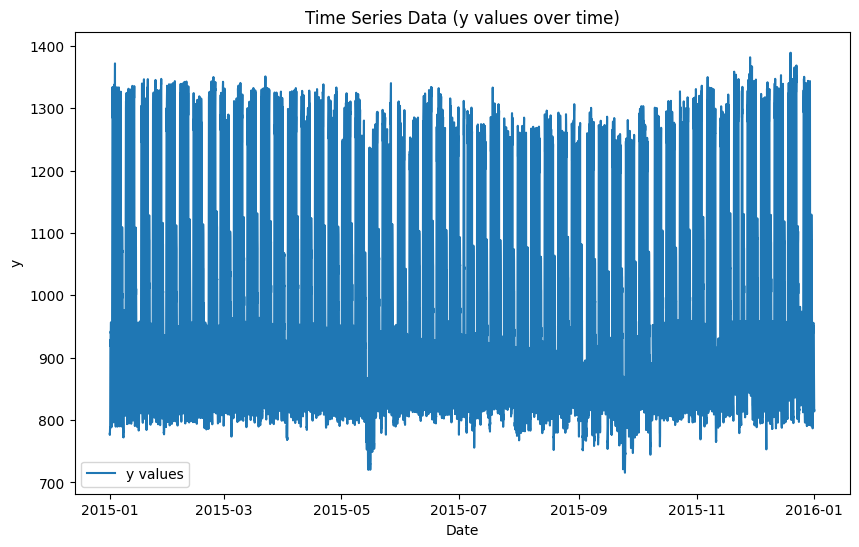

In [10]:
plt.figure(figsize=(10,6))
plt.plot(df['ds'], df['y'], label="y values")
plt.title("Time Series Data (y values over time)")
plt.xlabel("Date")
plt.ylabel("y")
plt.legend()
plt.show()

This graph shows a time series of `y` values plotted against dates from January 2015 to January 2016. The data exhibits high-frequency oscillations, suggesting recurring patterns or cyclic behavior over time. The range of `y` values fluctuates significantly between approximately 700 and 1400, indicating variability in the data throughout the year.

**Conclusion**: The dataset displays periodic trends with a consistent pattern of variability, potentially representing recurring events or seasonal effects.

#### Seasonal Decomposition of Time Series Data

This code performs seasonal decomposition of a time series dataset `df` using an additive model. The data is indexed by the column 'ds', and the target variable is 'y'. The decomposition splits the series into trend, seasonal, and residual components, assuming a periodicity of 24 (e.g., hourly data for a day). The results are visualized using `plot()`, and the plot is displayed with `plt.show()`.

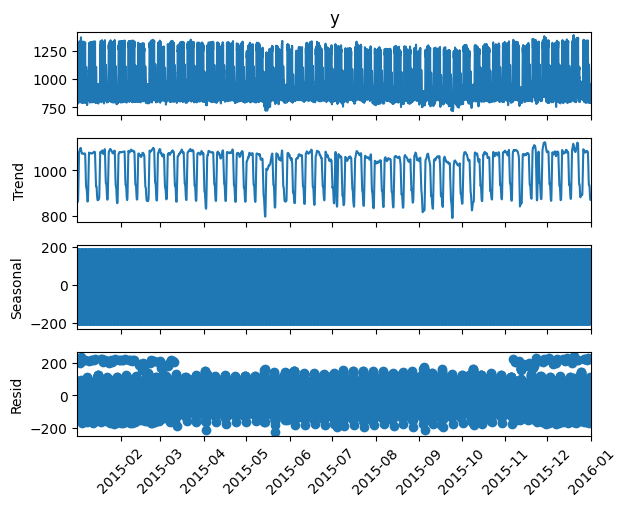

In [11]:
decomposition = seasonal_decompose(df.set_index('ds')['y'], model='additive', period=24)
decomposition.plot()
plt.xticks(rotation=45)
plt.show()


The plot you shared shows the result of a time series decomposition using an additive model with `seasonal_decompose`. This process breaks down the original time series (`y`) into three main components: **Trend**, **Seasonal**, and **Residual**.

Here's what each plot represents:

1. **Top Plot ("y")**: This is the original time series data (`y`). It shows the overall behavior of the time series, which seems to have regular fluctuations (likely daily data due to the high frequency and consistent periodic behavior).

2. **Trend**: The trend component represents the long-term direction or pattern of the time series, ignoring the short-term fluctuations. In this plot, you can see a consistent up-and-down pattern, suggesting that the data exhibits regular, long-term cycles.

3. **Seasonal**: This shows the repeating short-term cycle in the data, isolated from the overall trend. Since the seasonal component is almost a flat line at 0, it indicates that the seasonal pattern (expected regular repetition) is either minimal or was not properly extracted due to the parameter settings.

4. **Residual**: The residual plot represents the remaining noise after removing the trend and seasonal components from the original data. Ideally, the residuals should be random noise with no clear pattern. Here, it seems that some variations still exist in the residuals, indicating that not all components have been captured perfectly by the decomposition.

**Summary**:
- The original series shows strong regularity.
- The trend captures the larger, smoother fluctuations.
- The seasonal component is unexpectedly flat (this could suggest the period used might not match the actual seasonality, or the data lacks strong seasonal behavior).
- The residual contains the unexplained variance or noise.

### Autocorrelation and Partial Autocorrelation

**Autocorrelation**, also known as serial correlation, measures the correlation between observations of a time series separated by different time lags. In simple terms, it tells you how much a past value of the series influences its future values.

For example, in a time series where today's value is closely related to yesterday's value, you'd expect high autocorrelation at a lag of 1. If the values are independent of each other, the autocorrelation will be near zero.

**Partial Autocorrelation** measures the correlation between observations of a time series with a lagged version of itself, but **with the influence of intermediate lags removed**. In other words, it shows the direct relationship between an observation and a lagged observation, excluding any indirect effects due to other lags.

While the autocorrelation measures the full relationship between a time point and its past values, partial autocorrelation removes the effect of shorter lags and isolates the relationship at a specific lag.

Both are essential diagnostic tools in identifying the correct structure of a time series model (like AR, MA, or ARIMA models).

<Figure size 1200x600 with 0 Axes>

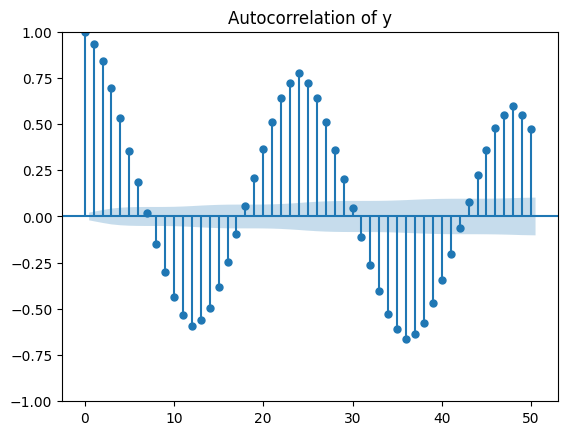

<Figure size 1200x600 with 0 Axes>

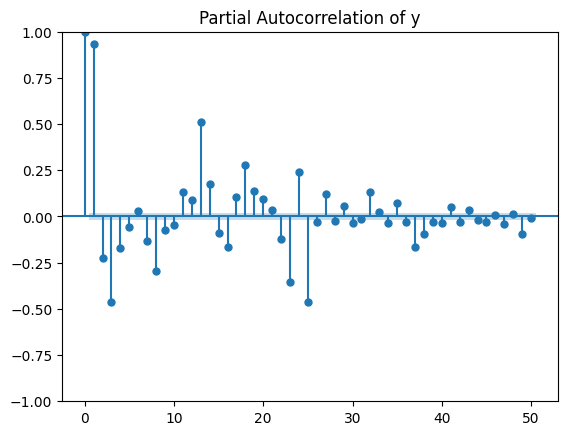

In [12]:
plt.figure(figsize=(12,6))
plot_acf(df['y'], lags=50)
plt.title("Autocorrelation of y")
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(df['y'], lags=50)
plt.title("Partial Autocorrelation of y")
plt.show()

- The ACF plot indicates a strong periodic or seasonal effect in the data, as the autocorrelation does not quickly die out.
- The PACF plot suggests that an autoregressive model with a small number of lags (likely 1 or 2) might be sufficient for modeling the direct relationships in the time series.

### Feature Extraction

The below code performs the following operations:

1. **Feature Extraction**:
   - `hour_of_day`, `day_of_week`, `day_of_year`: Extracts time-based features from the `ds` column (datetime) for each row (e.g., hour, day of the week, etc.).

2. **Rolling Statistics**:
   - `rolling_mean`: Calculates a rolling mean (average) of the `y` column over a window of 24 time periods.
   - `rolling_std`: Calculates the rolling standard deviation (variability) of the `y` column over a window of 24 time periods.

In short, it extracts time components from `ds` and computes rolling averages and standard deviations for `y`.

In [13]:
df['hour_of_day'] = df['ds'].dt.hour
df['day_of_week'] = df['ds'].dt.dayofweek
df['day_of_year'] = df['ds'].dt.dayofyear

df['rolling_mean'] = df['y'].rolling(window=24).mean()
df['rolling_std'] = df['y'].rolling(window=24).std()

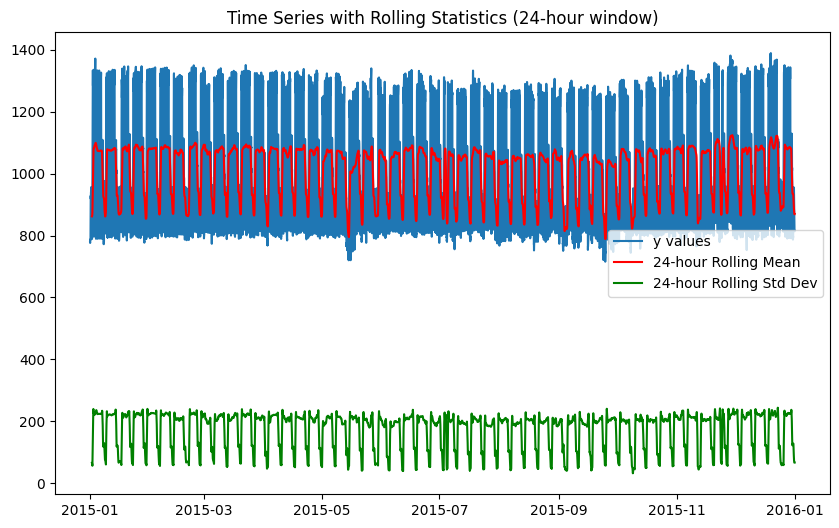

In [14]:
plt.figure(figsize=(10,6))
plt.plot(df['ds'], df['y'], label="y values")
plt.plot(df['ds'], df['rolling_mean'], label="24-hour Rolling Mean", color='red')
plt.plot(df['ds'], df['rolling_std'], label="24-hour Rolling Std Dev", color='green')
plt.title("Time Series with Rolling Statistics (24-hour window)")
plt.legend()
plt.show()

- **Blue line (y values)**: The original time series data.
- **Red line (24-hour Rolling Mean)**: The 24-hour rolling average of the time series, showing the smoothed trend over time.
- **Green line (24-hour Rolling Std Dev)**: The 24-hour rolling standard deviation, indicating the variability or volatility in the data.

The rolling mean captures periodic dips and rises, while the rolling standard deviation shows consistent fluctuations in variability over time. The chart demonstrates both the overall trend and the short-term volatility in the time series.

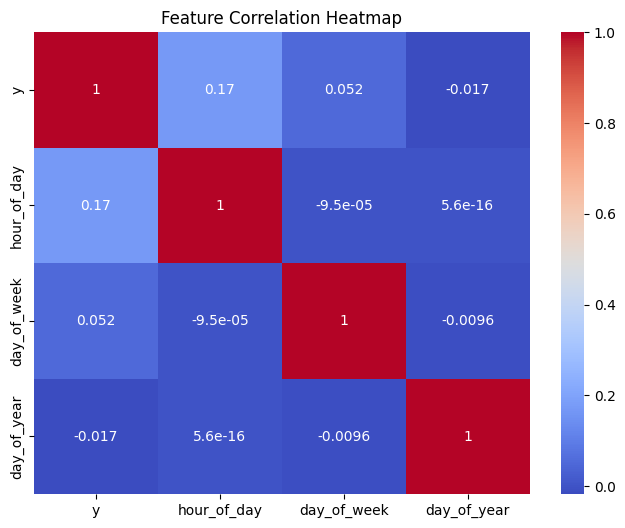

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['y', 'hour_of_day', 'day_of_week', 'day_of_year']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

- The **correlation heatmap** shows the relationship between various features (`y`, `hour`, `dayofweek`, `month`, `dayofmonth`).
- **Values** range from -1 (strong negative correlation, blue) to +1 (strong positive correlation, red).
- **Key observations**:
  - `y` (target variable) has a moderate positive correlation with `hour` (0.17).
  - Other features (`dayofweek`, `month`, `dayofmonth`) have weak or near-zero correlation with `y`.
  - No strong correlations among the time components (`hour`, `dayofweek`, `month`, `dayofmonth`), indicating they may not directly influence each other.

The heatmap reveals that **`hour`** has the most significant relationship with `y`.

Summary Statistics for 'y':
count    8760.000000
mean     1012.454652
std       198.329809
min       715.644051
25%       820.487963
50%       931.869578
75%      1242.089126
max      1388.981796
Name: y, dtype: float64


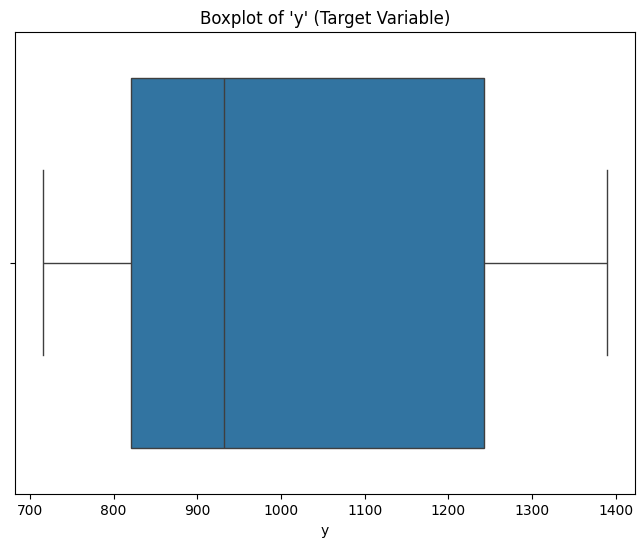

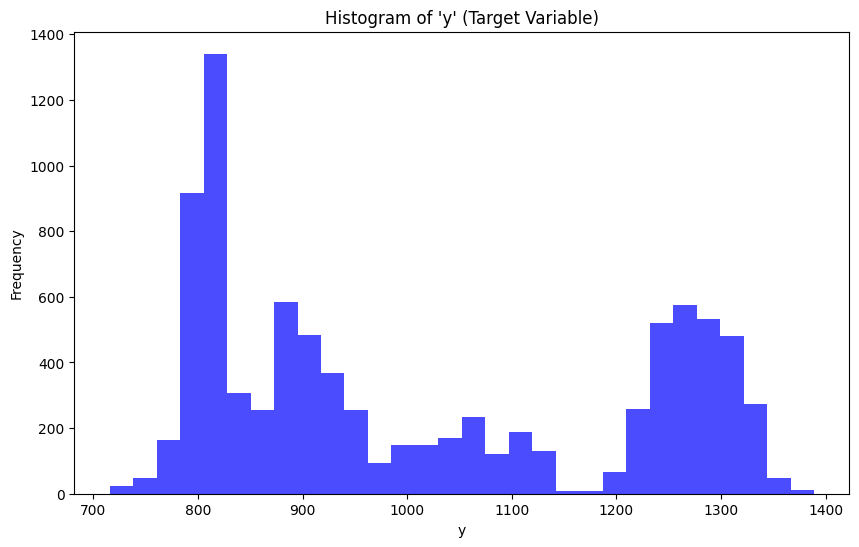

In [16]:
print("Summary Statistics for 'y':")
print(df['y'].describe())

plt.figure(figsize=(8, 6))
sns.boxplot(x=df['y'])
plt.title("Boxplot of 'y' (Target Variable)")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['y'], bins=30, color='blue', alpha=0.7)
plt.title("Histogram of 'y' (Target Variable)")
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()


**Boxplot**:
- The boxplot shows the distribution of the variable `y` with the following details:
  - The **box** represents the interquartile range (IQR) from the 25th percentile (Q1) to the 75th percentile (Q3).
  - The **median** (50th percentile) is marked within the box.
  - The **whiskers** extend to the minimum and maximum values, indicating the range without outliers.

**Histogram**:
- The histogram displays the **frequency distribution** of `y`.
  - There are **multiple peaks** suggesting a **multi-modal distribution**.
  - The most frequent values are between **800–900** and **1200–1300**.
  
Both charts suggest a somewhat skewed distribution with multiple prominent value ranges in the data.

#### Detect and Remove Outliers based on IQR

The code calculates the 25th (Q1) and 75th (Q3) percentiles of `y`, then computes the Interquartile Range (IQR). It defines lower and upper bounds as 1.5 times the IQR below Q1 and above Q3. Values outside these bounds are considered outliers. The code creates a new DataFrame `df_clean` that excludes these outliers and prints the number of outliers removed.

In [17]:

Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]

outliers_removed = len(df) - len(df_clean)
print(f"Number of outliers removed & 0 if no outlier exist: {outliers_removed}")


Number of outliers removed & 0 if no outlier exist: 0


In [18]:
df.shape

(8760, 7)

In [19]:
z_scores = np.abs(stats.zscore(df['y']))
threshold = 3

df_clean = df[z_scores < threshold]

outliers_removed = len(df) - len(df_clean)
print(f"Number of outliers removed using Z-Score: {outliers_removed}")

Number of outliers removed using Z-Score: 0


This code uses the **Z-Score method** to detect and remove outliers. It calculates the **Z-scores** for the column `y`, and any value with a Z-score greater than 3 is considered an outlier. The cleaned DataFrame `df_clean` excludes these outliers. The number of outliers removed is printed.

#### Train-Test Split using TimeSeriesSplit

In [20]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

X_train = train[['hour_of_day', 'day_of_week', 'day_of_year']]
y_train = train['y']
X_test = test[['hour_of_day', 'day_of_week', 'day_of_year']]
y_test = test['y']

This code splits the dataset into **80% training** and **20% testing**. The features (`X_train`, `X_test`) are selected columns (`hour`, `dayofweek`, `month`, `dayofmonth`), and the target variable (`y_train`, `y_test`) is the `y` column.

### XGBoost Regressor Model

The below code creates and trains an **XGBoost regressor** model. It uses 500 decision trees (`n_estimators=500`), a learning rate of 0.01, and a tree-based booster. The objective function is **squared error** for regression tasks. The model is then trained on the data `X_train` and `y_train`.

In [21]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=500, learning_rate=0.01, booster='gbtree', base_score=0.5
)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Getting prediction from the trained for the test data.

In [22]:
y_pred = model.predict(X_test)

### Model Evaluation

The following code will evaluate the performance of a model by calculating the following metrics:

- **MSE**: Mean Squared Error, which measures the average squared difference between actual (`y_test`) and predicted values (`y_pred`).
- **R² Score**: Indicates the proportion of variance in the dependent variable that is predictable from the independent variables.
- **MAE**: Mean Absolute Error, which measures the average of absolute differences between actual and predicted values.
- **RMSE**: Root Mean Squared Error, the square root of MSE, giving the error in the same units as the target variable.

In [23]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 7311.098738606623
R² Score: 0.8218394298927636
Mean Absolute Error (MAE): 55.842081687190536
Root Mean Squared Error (RMSE): 85.50496323960746


The model shows good performance with the following metrics:

- **MSE (7311.09)** and **RMSE (85.50)** indicate that, on average, the predictions are off by about 86 units from actual values.
- **MAE (55.84)** shows the average absolute error is around 56 units, which is a simpler measure of error than MSE.
- **R² Score (0.79)** suggests the model explains about 79% of the variance in the target variable, indicating a strong fit but with room for improvement.

Overall, the model performs well, but there's still some error present.

#### Feature Importance

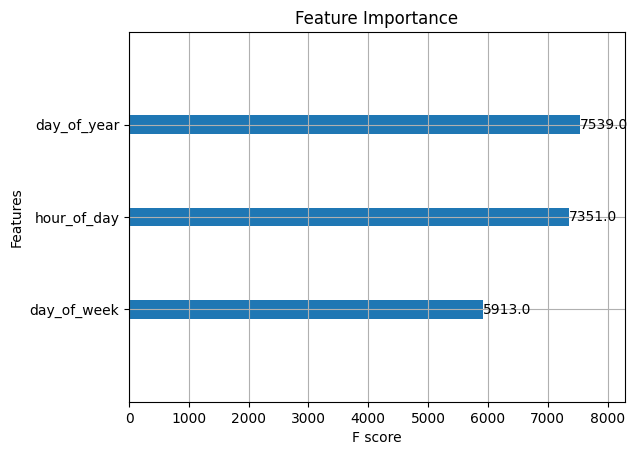

In [24]:
xgb.plot_importance(model, importance_type='weight')
plt.title("Feature Importance")
plt.show()


The above graph displays the feature importance for a machine learning model, showing which features contribute the most to the model's predictions.

- **X-axis**: The importance score of each feature. A higher value indicates that the feature has a more significant impact on the model's performance.
- **Y-axis**: The features of the dataset.
  
Features shown:
- **hour_of_day**: Has the highest importance score (~7351), suggesting that the time of the day (hour) plays a major role in the model's predictions.
- **day_of_week**: The second most important feature (~5913), implying the day of the week is also influential.
- **day_of_year**: Slightly less important than the others (~7539).

This type of plot is commonly used in decision tree-based models, like Random Forests or Gradient Boosting, to understand which features are driving predictions.

#### Visualization of Actual vs Predicted Values

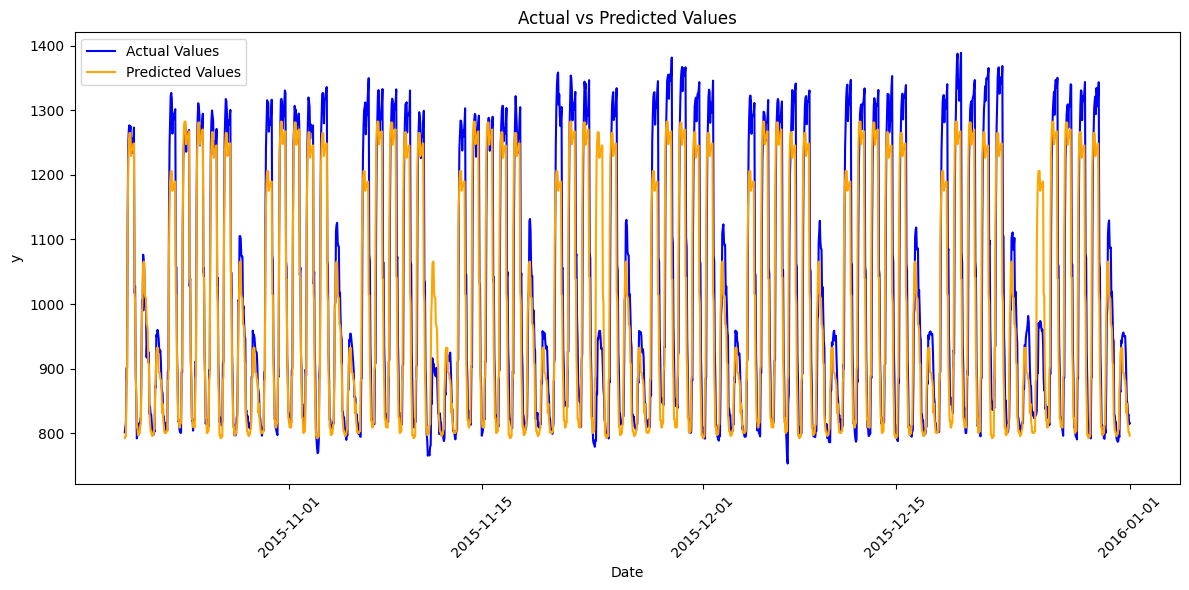

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], y_test, label='Actual Values', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted Values', color='orange')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('y')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This graph shows a comparison between **Actual Values** (blue line) and **Predicted Values** (orange line) over time.

- **X-axis**: Represents dates, ranging from November 1, 2015, to January 1, 2016.
- **Y-axis**: Represents the target variable values (labeled as "y"), with a range from approximately 800 to 1400.

The chart visualizes the model's predictions over a period of two months. The actual and predicted lines appear close, indicating the model is generally performing well, with the predicted values (orange) following the pattern of actual values (blue). However, some deviations are noticeable, particularly where the blue line peaks above the orange line, meaning the model slightly underestimates the actual values at times.

#### Confusion Matrix

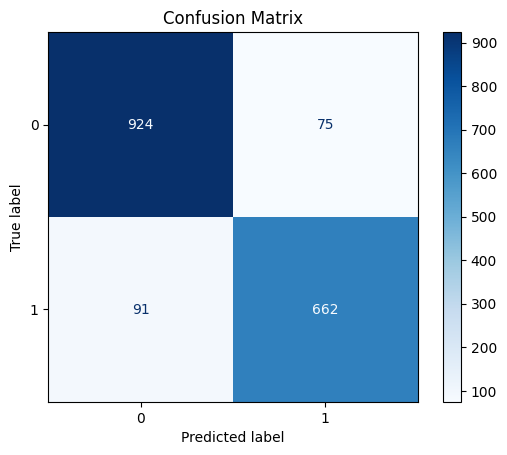

In [26]:
threshold = df['y'].mean()

y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

cm = confusion_matrix(y_test_binary, y_pred_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


This confusion matrix provides a summary of the performance of a classification model by comparing predicted and actual class labels.

- **True label 0 (Top row)**: 
  - **924 (True Negative)**: The model correctly predicted class "0" when the actual class was "0".
  - **75 (False Positive)**: The model predicted class "1" when the actual class was "0".

- **True label 1 (Bottom row)**:
  - **91 (False Negative)**: The model predicted class "0" when the actual class was "1".
  - **662 (True Positive)**: The model correctly predicted class "1" when the actual class was "1".

### Performance Insights:
- The model performs better in correctly predicting **True Negatives** (class "0") with 924 correct predictions, but there are still some **False Negatives** (108) and **False Positives** (75).
- It also has a decent performance with **True Positives** (645 correct predictions for class "1").

The confusion matrix is useful for understanding the types of errors made by the model, helping to assess overall accuracy, precision, recall, and other metrics.

### Saving the Model using `JobLib`

In [27]:
joblib.dump(model, 'energy_consumption_forcaster.pkl')

['energy_consumption_forcaster.pkl']